# Image classification

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

### Data preprocessing

In [2]:
training_dir = 'dataset/training'
validation_dir = 'dataset/validation'
test_dir = 'dataset/test'

BATCH_SIZE = 32
IMG_SIZE = (150, 150)

In [3]:
training_dataset = tf.keras.utils.image_dataset_from_directory(training_dir,
                                                               shuffle=True,
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE)

Found 13140 files belonging to 6 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2580 files belonging to 6 classes.


### Explore the training dataset

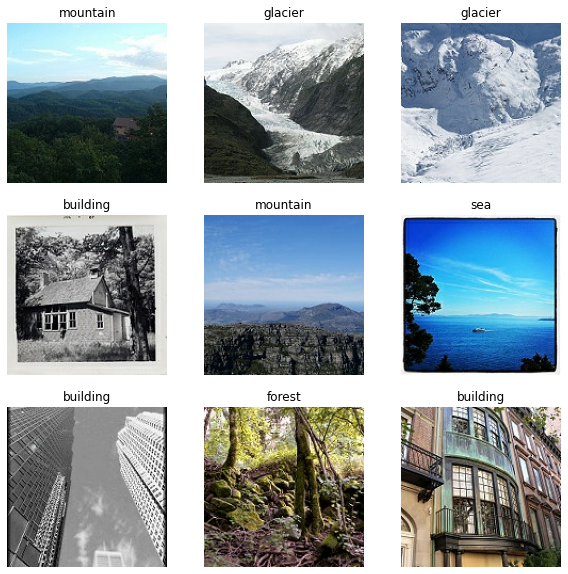

In [5]:
class_names = training_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Data augmentation

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.

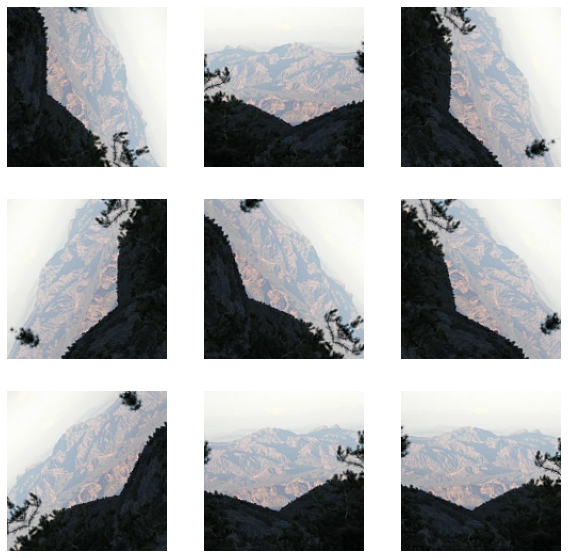

In [7]:
for image, _ in training_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

We will use `tf.keras.applications.MobileNetV2` as our base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### Create the base model from the pre-trained convnets
We will create the base model from the **MobileNet V2** model developed at Google.

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

In [10]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image.

In [12]:
prediction_layer = tf.keras.layers.Dense(len(class_names))

Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional).

In [13]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [14]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.00001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

### Model training

In [ ]:
model.fit(training_dataset,
          epochs=20,
          validation_data=validation_dataset)

Epoch 1/20
411/411 [==============================] - 117s 278ms/step - loss: 11.0033 - accuracy: 0.1301 - val_loss: 11.2156 - val_accuracy: 0.1461
Epoch 2/20
411/411 [==============================] - 113s 276ms/step - loss: 10.6327 - accuracy: 0.1455 - val_loss: 10.4820 - val_accuracy: 0.1519
Epoch 3/20
411/411 [==============================] - 115s 280ms/step - loss: 10.2089 - accuracy: 0.1635 - val_loss: 9.6621 - val_accuracy: 0.1667
Epoch 4/20
411/411 [==============================] - 110s 268ms/step - loss: 9.5145 - accuracy: 0.1759 - val_loss: 8.5840 - val_accuracy: 0.1733
Epoch 5/20
411/411 [==============================] - 110s 269ms/step - loss: 8.7449 - accuracy: 0.1852 - val_loss: 7.2927 - val_accuracy: 0.1853
Epoch 6/20
411/411 [==============================] - 112s 271ms/step - loss: 7.9779 - accuracy: 0.1938 - val_loss: 6.2983 - val_accuracy: 0.1950
Epoch 7/20
411/411 [==============================] - 109s 266ms/step - loss: 7.0274 - accuracy: 0.2041 - val_loss: 5.1

### Prediction

In [ ]:
import pathlib
import numpy as np

class_names = training_dataset.class_names

dataset_dir = pathlib.Path('dataset')

dataset_test_dir = list(dataset_dir.glob('test/*'))

for i in range(10):
    path_to_file = str(dataset_test_dir[i])
    img = tf.keras.utils.load_img(path_to_file, target_size=IMG_SHAPE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print("This image most likely belongs to {} with a {:.2f} percent confidence."
          .format(class_names[np.argmax(score)], 100 * np.max(score)))

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  path_to_file = str(dataset_test_dir[i])
  img = tf.keras.utils.load_img(path_to_file, target_size=IMG_SHAPE)
  img_array = tf.keras.utils.img_to_array(img)
  
  plt.imshow(img_array.astype("uint8"))

  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  plt.title(class_names[np.argmax(score)])

  plt.axis("off")